In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def visualize(data, y, x, hues, chart):
    plt.figure(figsize=(12,8))
    match chart:
        case 'line':
            chart_type = sns.lineplot
        case 'bar':
            chart_type = sns.barplot
        case 'box':
            chart_type = sns.boxplot
    try:
        if len(hues) > 1:
            data['hues'] = data[hues].astype(str).agg('-'.join, axis=1)
        else:
            data['hues'] = data[hues[0]]

        chart_type(data=data,x = x, y = y, hue='hues', palette='viridis')

        plt.legend(title=f'{y} for {x}, sorted by {[h + ", " for h in hues]}')
        plt.show()
    except (KeyError, ValueError) as e:
        print(f"You've passed an incorrect column name.\n The correct ones are: \n{data.columns}\nException: {e}")
    


In [2]:
import networkx as nx
from MaxCutProblem import MaxCutProblem
from solver import Solver

problem = MaxCutProblem()
# Create an Erdos-Renyi graph
graphs = problem.get_erdos_renyi_graphs([5, 7, 9])
dictionary = {}
for graph in graphs:
    solver = Solver(graph, lagrangian=2, vertexcover=True)

    # Convert the graph to a NetworkX graph
    nx_graph = nx.Graph(list(graph.edge_list()))
    graph6_string = nx.to_graph6_bytes(nx_graph).decode('utf-8').strip()

    # Solve the problem using the solver
    bitstring, objvalue = solver.solve()
    print(f'Solution, objective value for graph {graph6_string} is {objvalue}')
    
    # Add the result to the dictionary
    dictionary[graph6_string] = objvalue

print(dictionary)

Solution, objective value for graph >>graph6<<DkO is 2.0
Solution, objective value for graph >>graph6<<Dm{ is 3.0
Solution, objective value for graph >>graph6<<FkPsg is 4.0
Solution, objective value for graph >>graph6<<Fm~]w is 5.0
Solution, objective value for graph >>graph6<<HkPsgZ@ is 5.0
Solution, objective value for graph >>graph6<<Hm~]x^^ is 7.0
{'>>graph6<<DkO': 2.0, '>>graph6<<Dm{': 3.0, '>>graph6<<FkPsg': 4.0, '>>graph6<<Fm~]w': 5.0, '>>graph6<<HkPsgZ@': 5.0, '>>graph6<<Hm~]x^^': 7.0}


### Configure the results you want to visualize under.



In [3]:
import ast
import numpy as np


"""strings = ["results/results_papergraph_depth_{2, 10}_vertexcover_50RI.csv",
           "results/results_papergraph_depth_{2, 10}MaxCut_50RI.csv",
           "results/results_papergraph_depth_{2, 4, 6, 8, 10}.csv",
           "results/results_papergraph_depth_{2, 10}.csv"]"""
strings = ['results/results_papergraph_depth_{2, 4, 6, 8, 10}.csv',
            'results/results_papergraph_depth_{2, 4, 6}.csv',
            'results/results_papergraph_depth_{8, 10}.csv']



for file in strings:
    try:
        df = pd.read_csv(file)
        print(f"File: {file}")
        print(df['graph_name'].value_counts())
        print("\n")
    except FileNotFoundError:
        print(f"File not found: {file}")

if len(strings) >1:
    results = pd.concat([pd.read_csv(path,index_col=0) for path in strings])

else:
    results = pd.read_csv(strings[0])

#results['classic_value'] = results['classic_solution'].apply(lambda x: np.sum(ast.literal_eval(x)))
results['ratio'] = results['quantum_obj_value']/results['classic_value']
#results = results[~results['depth'].isin([4, 6, 8])]
#results.drop('Unnamed: 0', axis=1, inplace=True)

#rint(results.head())
print(results.head())



File: results/results_papergraph_depth_{2, 4, 6, 8, 10}.csv
graph_name
>>graph6<<DbS    250
>>graph6<<DxK    250
>>graph6<<Dv[    250
Name: count, dtype: int64


File: results/results_papergraph_depth_{2, 4, 6}.csv
graph_name
>>graph6<<DbS    150
>>graph6<<DxK    150
>>graph6<<Dv[    150
Name: count, dtype: int64


File: results/results_papergraph_depth_{8, 10}.csv
graph_name
>>graph6<<DbS    100
>>graph6<<DxK    100
>>graph6<<Dv[    100
Name: count, dtype: int64


  param_initialization optimizer qaoa_variant  warm_start  errors  depth  \
0             gaussian    COBYLA      vanilla       False   False      2   
1             gaussian    COBYLA      vanilla       False   False      2   
2             gaussian    COBYLA      vanilla       False   False      2   
3             gaussian    COBYLA      vanilla       False   False      4   
4             gaussian    COBYLA      vanilla       False   False      4   

   lagrangian_multiplier  amount_shots       max_tol  error_mitigation  .

C:\Users\torbjsme\AppData\Local\Temp\ipykernel_22436\3079784610.py:22: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title=f'{y} for {x}, sorted by {[h + ", " for h in hues]}')


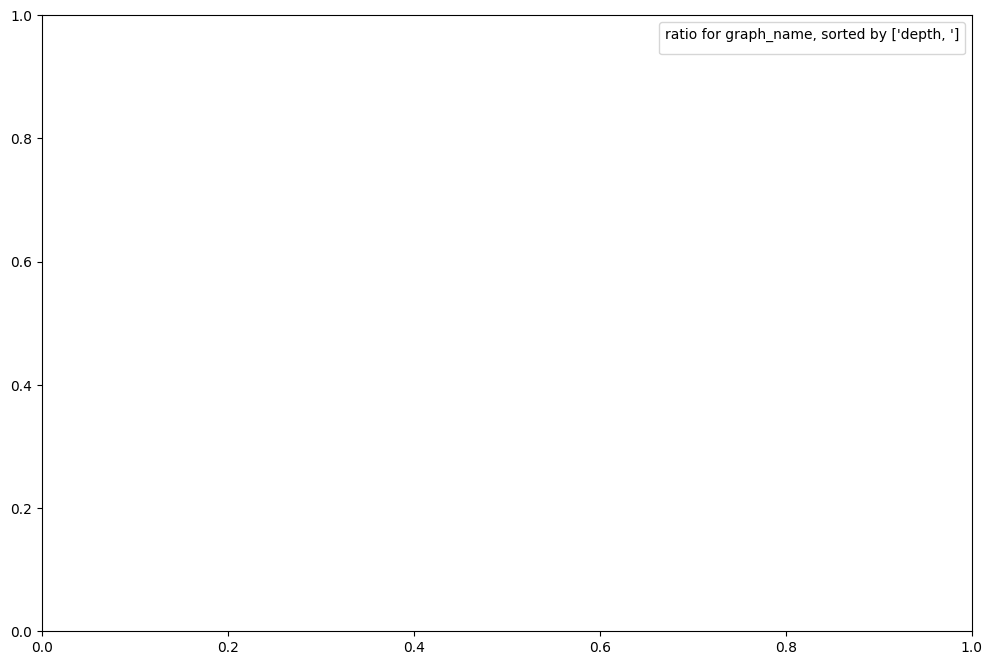

C:\Users\torbjsme\AppData\Local\Temp\ipykernel_22436\3079784610.py:22: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title=f'{y} for {x}, sorted by {[h + ", " for h in hues]}')


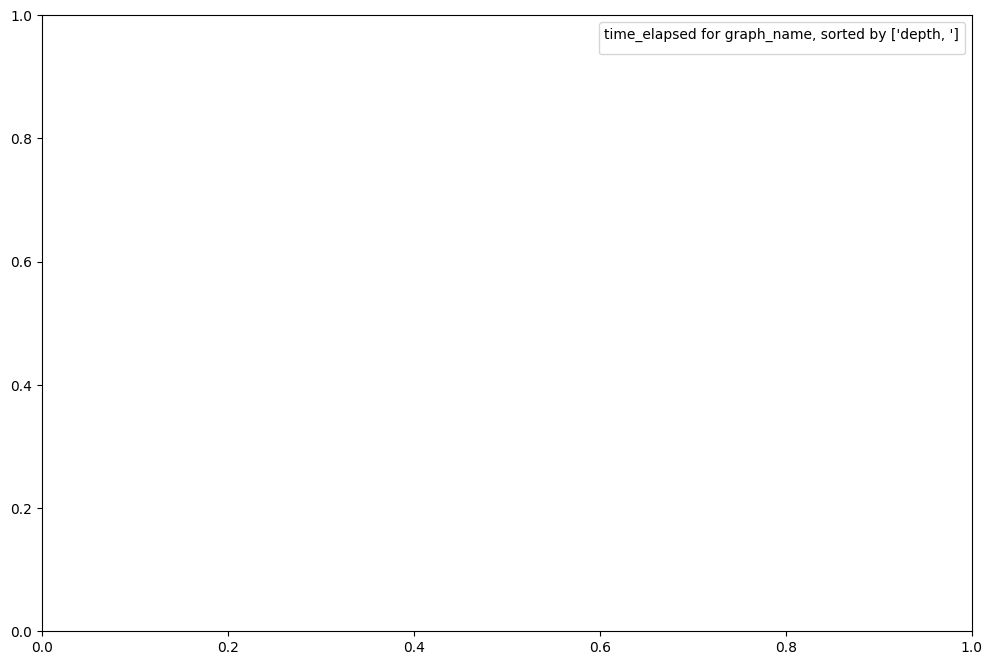

C:\Users\torbjsme\AppData\Local\Temp\ipykernel_22436\3079784610.py:22: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title=f'{y} for {x}, sorted by {[h + ", " for h in hues]}')


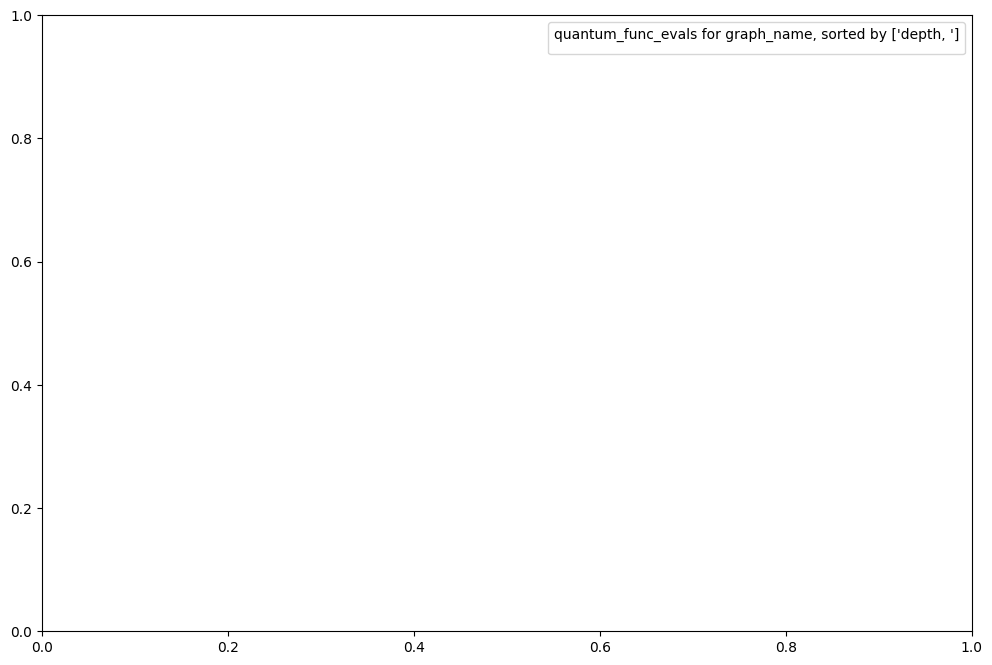

C:\Users\torbjsme\AppData\Local\Temp\ipykernel_22436\3079784610.py:22: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title=f'{y} for {x}, sorted by {[h + ", " for h in hues]}')


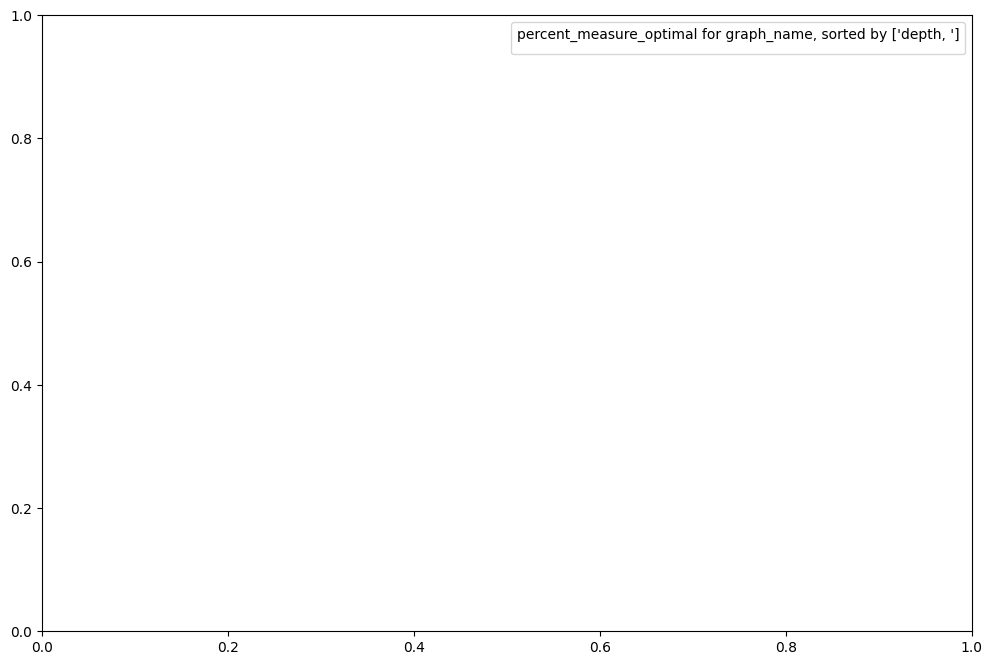

<Figure size 640x480 with 0 Axes>

In [4]:
results_maxcut = results[results['vertexcover'] ==False]

y_values = ['ratio', 'time_elapsed', 'quantum_func_evals', 'percent_measure_optimal']
x = 'graph_name'
hues = ['depth']

for y in y_values:
    visualize(results_maxcut, y, x, hues, 'bar')
plt.tight_layout()


C:\Users\torbjsme\AppData\Local\Temp\ipykernel_22436\3079784610.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['hues'] = data[hues].astype(str).agg('-'.join, axis=1)


Visualizing ratio for graph: >>graph6<<DbS


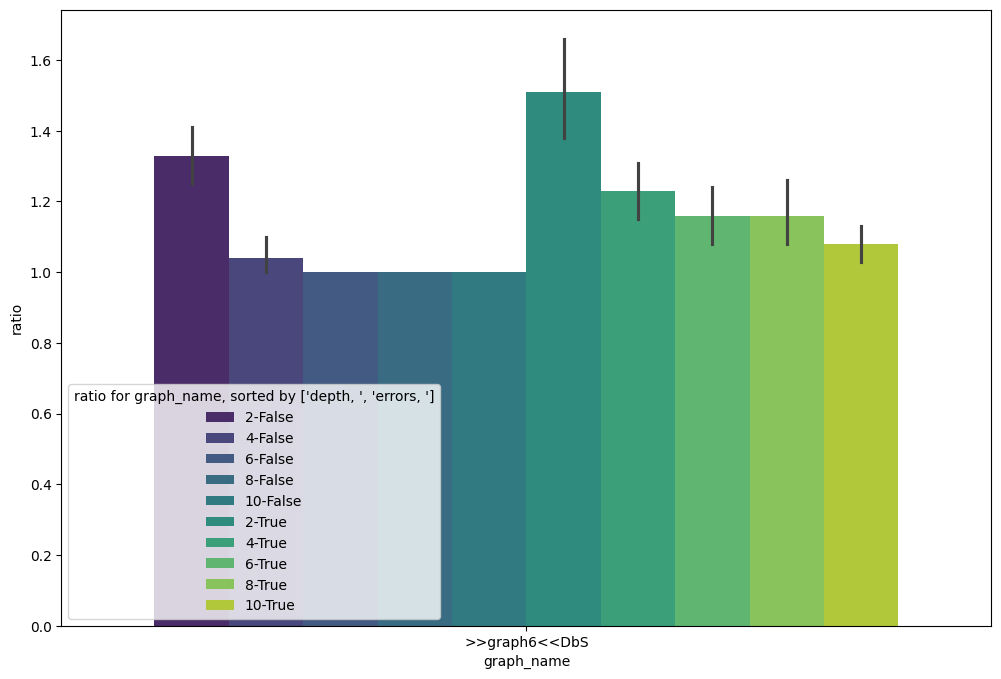

Visualizing time_elapsed for graph: >>graph6<<DbS


C:\Users\torbjsme\AppData\Local\Temp\ipykernel_22436\3079784610.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['hues'] = data[hues].astype(str).agg('-'.join, axis=1)


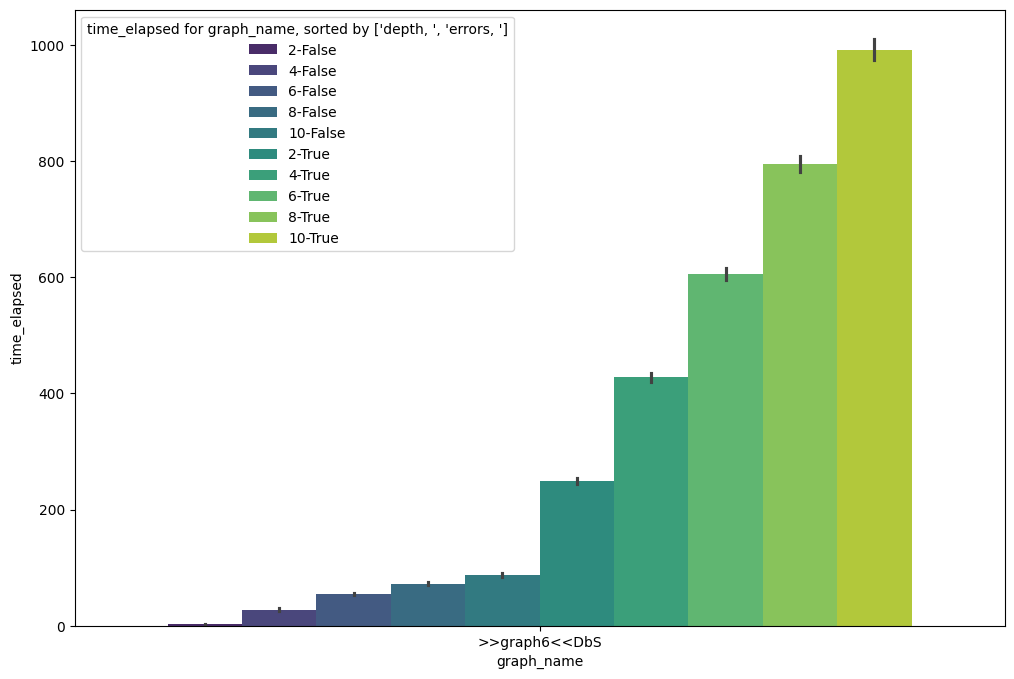

Visualizing quantum_func_evals for graph: >>graph6<<DbS


C:\Users\torbjsme\AppData\Local\Temp\ipykernel_22436\3079784610.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['hues'] = data[hues].astype(str).agg('-'.join, axis=1)


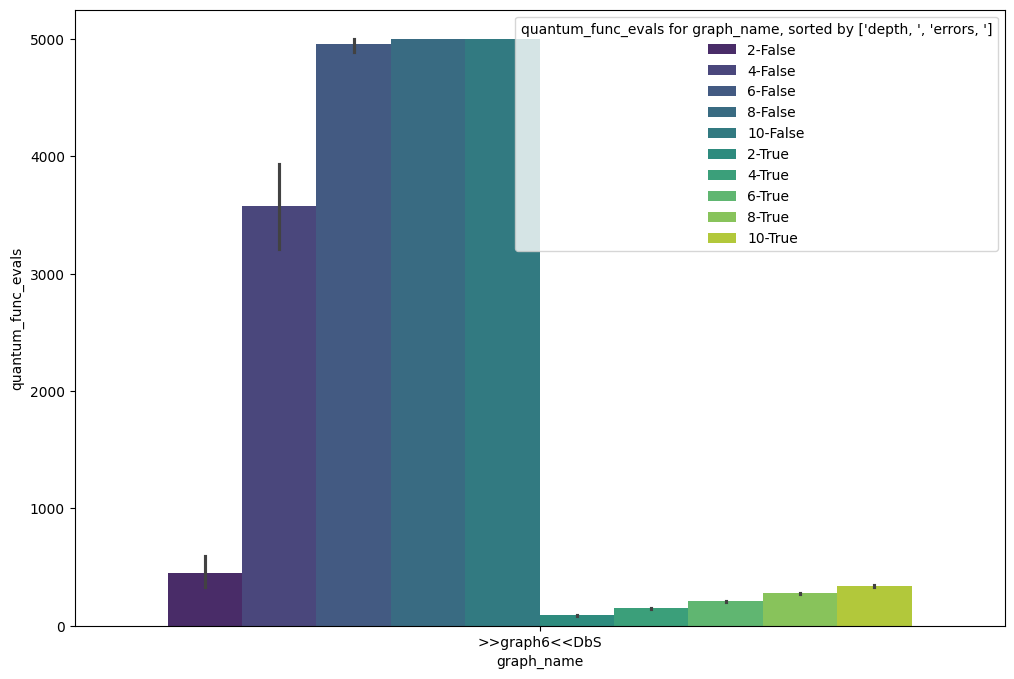

Visualizing percent_measure_optimal for graph: >>graph6<<DbS


C:\Users\torbjsme\AppData\Local\Temp\ipykernel_22436\3079784610.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['hues'] = data[hues].astype(str).agg('-'.join, axis=1)


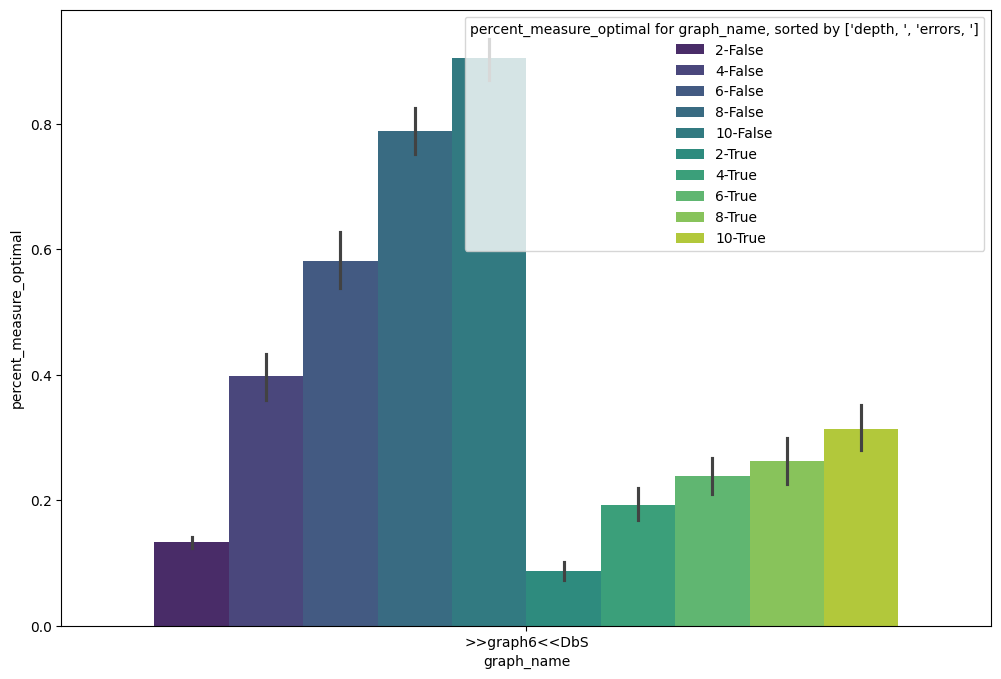

Visualizing ratio for graph: >>graph6<<DxK


C:\Users\torbjsme\AppData\Local\Temp\ipykernel_22436\3079784610.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['hues'] = data[hues].astype(str).agg('-'.join, axis=1)


<Figure size 640x480 with 0 Axes>

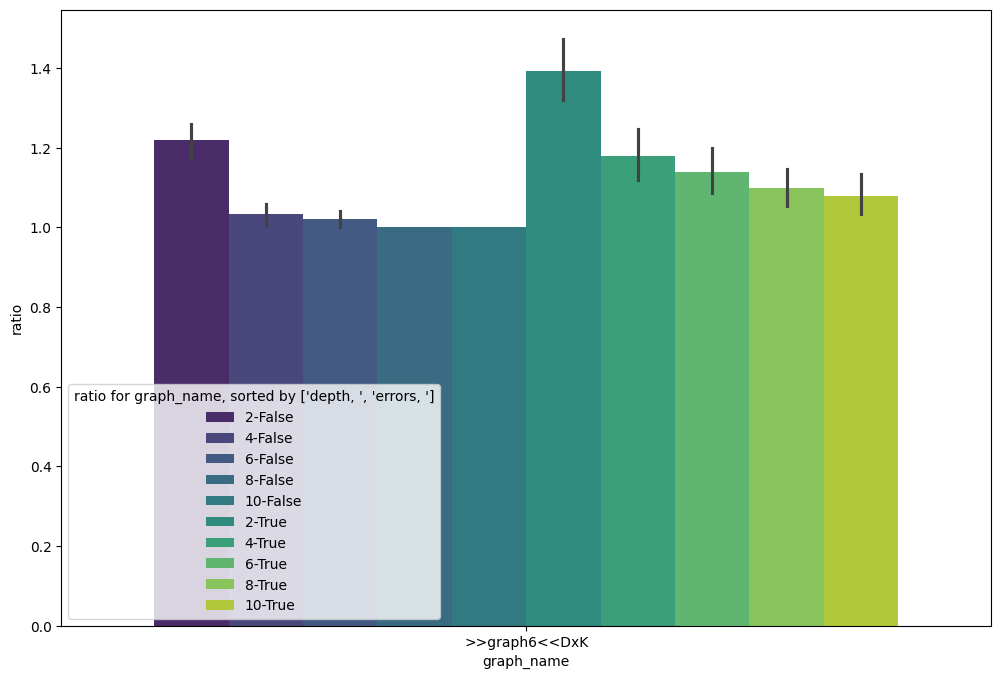

Visualizing time_elapsed for graph: >>graph6<<DxK


C:\Users\torbjsme\AppData\Local\Temp\ipykernel_22436\3079784610.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['hues'] = data[hues].astype(str).agg('-'.join, axis=1)


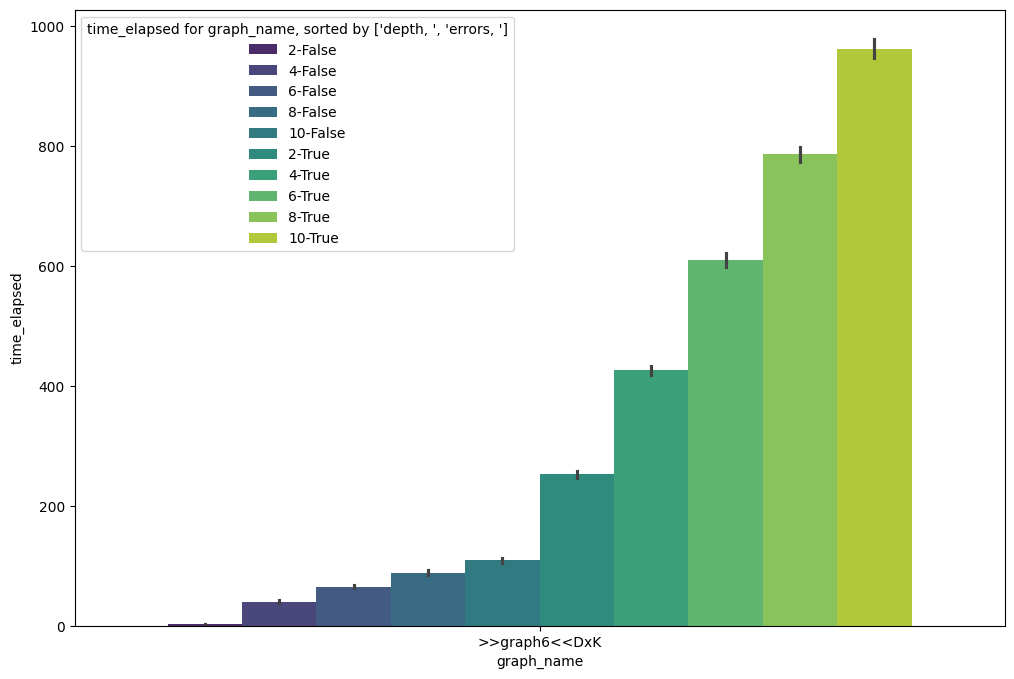

Visualizing quantum_func_evals for graph: >>graph6<<DxK


C:\Users\torbjsme\AppData\Local\Temp\ipykernel_22436\3079784610.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['hues'] = data[hues].astype(str).agg('-'.join, axis=1)


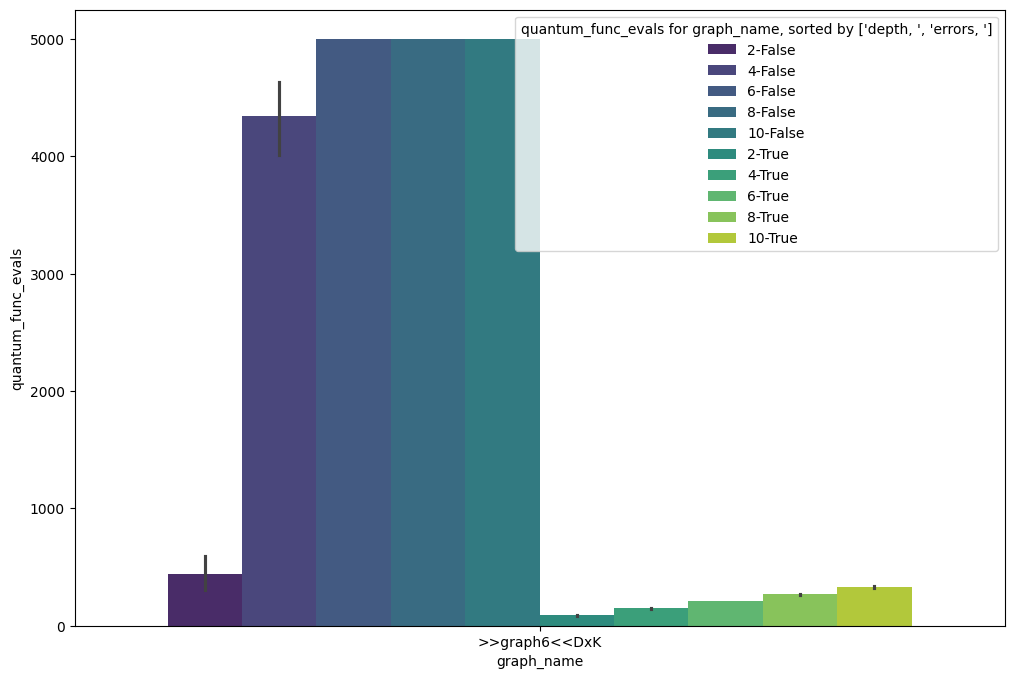

Visualizing percent_measure_optimal for graph: >>graph6<<DxK


C:\Users\torbjsme\AppData\Local\Temp\ipykernel_22436\3079784610.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['hues'] = data[hues].astype(str).agg('-'.join, axis=1)


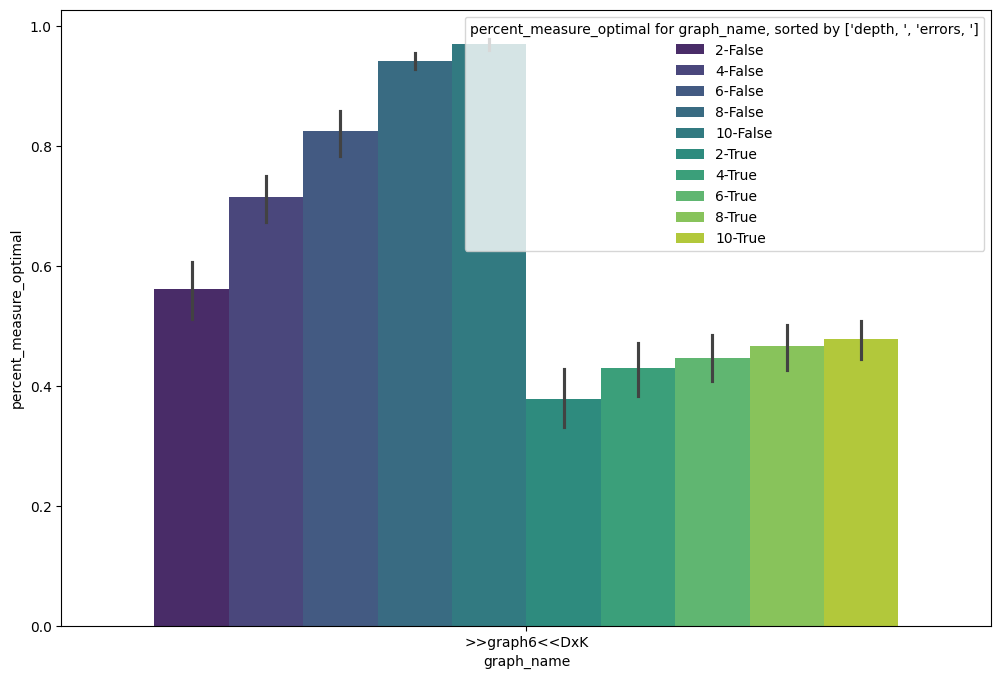

Visualizing ratio for graph: >>graph6<<Dv[


C:\Users\torbjsme\AppData\Local\Temp\ipykernel_22436\3079784610.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['hues'] = data[hues].astype(str).agg('-'.join, axis=1)


<Figure size 640x480 with 0 Axes>

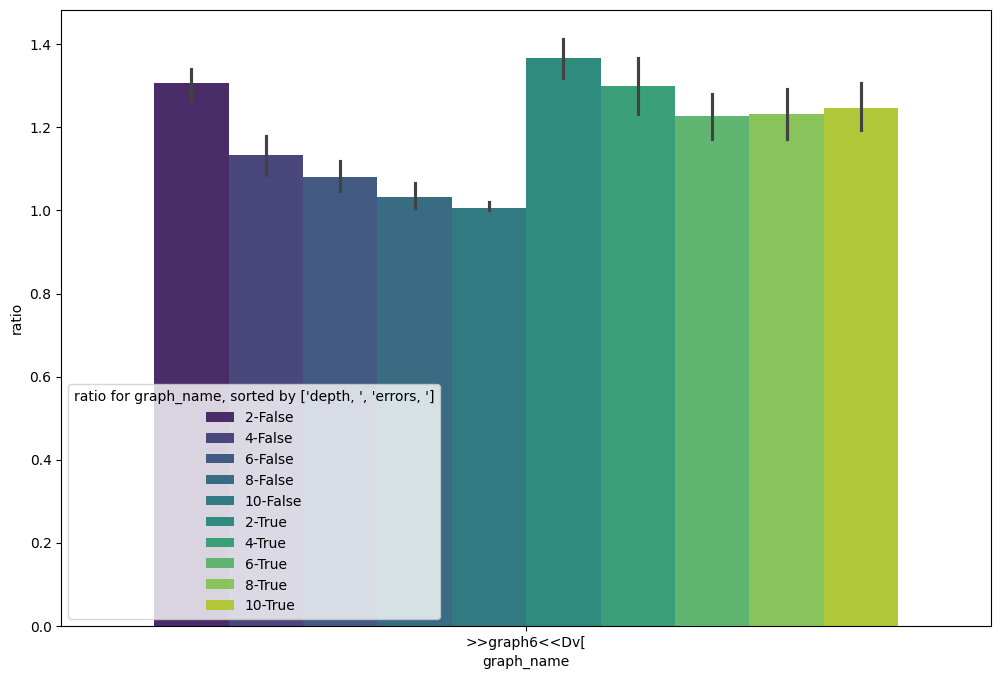

Visualizing time_elapsed for graph: >>graph6<<Dv[


C:\Users\torbjsme\AppData\Local\Temp\ipykernel_22436\3079784610.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['hues'] = data[hues].astype(str).agg('-'.join, axis=1)


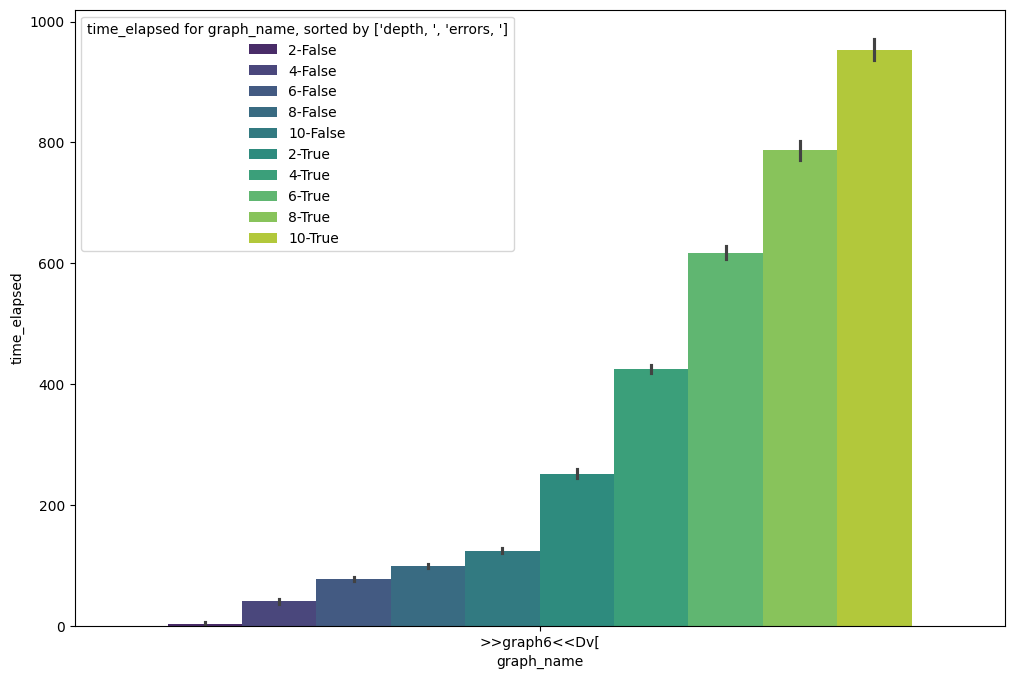

Visualizing quantum_func_evals for graph: >>graph6<<Dv[


C:\Users\torbjsme\AppData\Local\Temp\ipykernel_22436\3079784610.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['hues'] = data[hues].astype(str).agg('-'.join, axis=1)


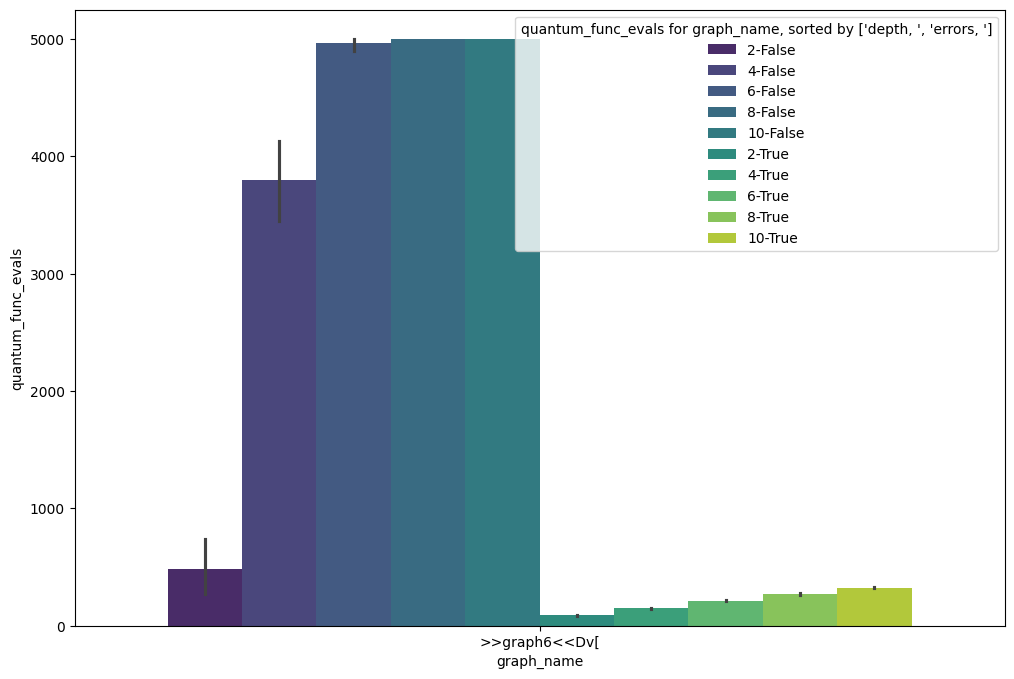

Visualizing percent_measure_optimal for graph: >>graph6<<Dv[


C:\Users\torbjsme\AppData\Local\Temp\ipykernel_22436\3079784610.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['hues'] = data[hues].astype(str).agg('-'.join, axis=1)


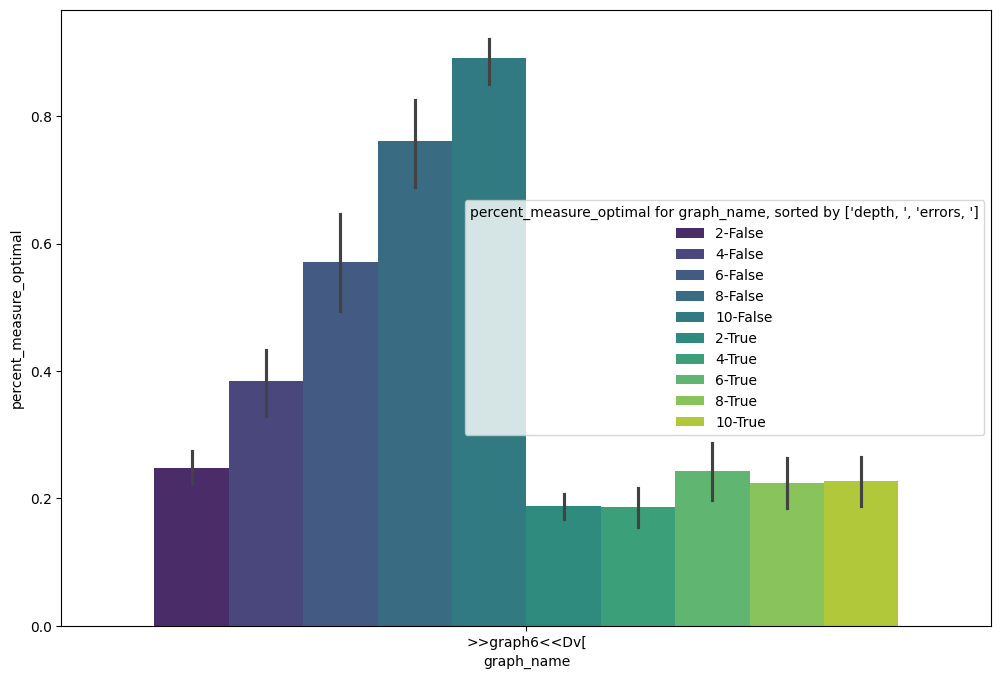

<Figure size 640x480 with 0 Axes>

In [5]:
results_maxcut = results[results['vertexcover'] == True]

y_values = ['ratio', 'time_elapsed', 'quantum_func_evals', 'percent_measure_optimal']
x = 'graph_name'
hues = ['depth', 'errors']

for graph_name in results_maxcut['graph_name'].unique():
    filtered_data = results_maxcut[results_maxcut['graph_name'] == graph_name]
    for y in y_values:
        print(f"Visualizing {y} for graph: {graph_name}")
        visualize(filtered_data, y, x, hues, 'bar')
    plt.tight_layout()


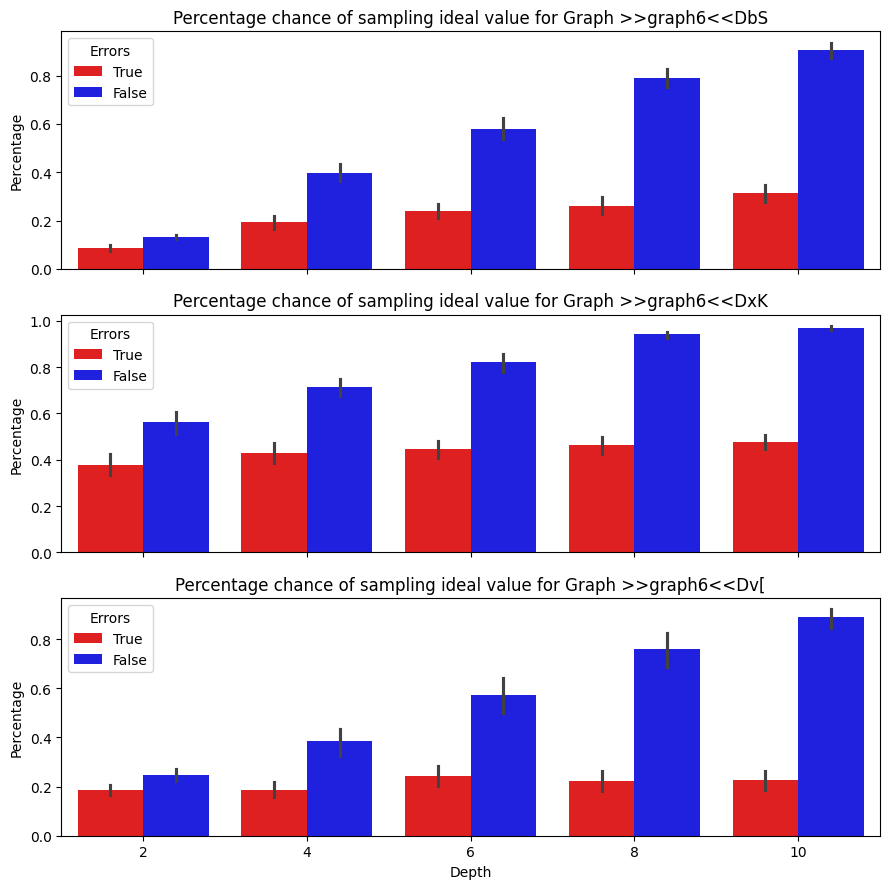

In [16]:
graph_names = results['graph_name'].unique()

fig, axes = plt.subplots(len(graph_names), 1, figsize=(9, 3 * len(graph_names)), sharex=True)

for i, graph_name in enumerate(graph_names):
    ax = axes[i] if len(graph_names) > 1 else axes
    sns.barplot(
        data=results[results['graph_name'] == graph_name],
        x='depth',
        y='percent_measure_optimal',
        hue='errors',
        hue_order=[True, False],  # Switch the order of errors
        palette=['red', 'blue'],  # Adjust colors to match the new order
        ax=ax
    )
    ax.set_xlabel('Depth')
    ax.set_ylabel('Percentage')
    ax.set_title(f'Percentage chance of sampling ideal value for Graph {graph_name}')
    ax.legend(title='Errors')

plt.tight_layout()
plt.show()

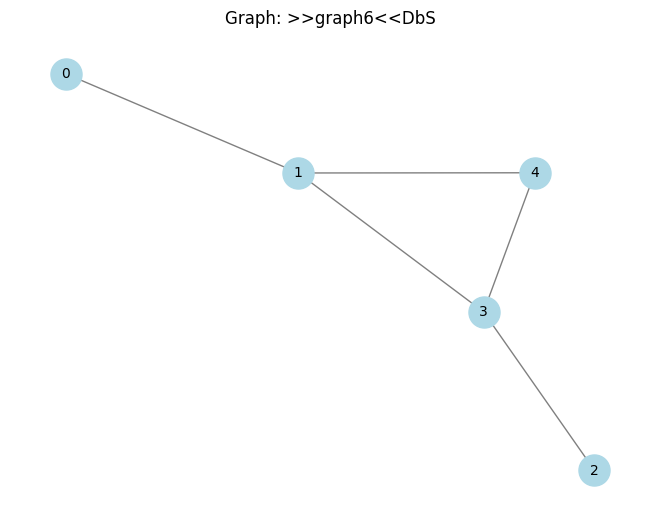

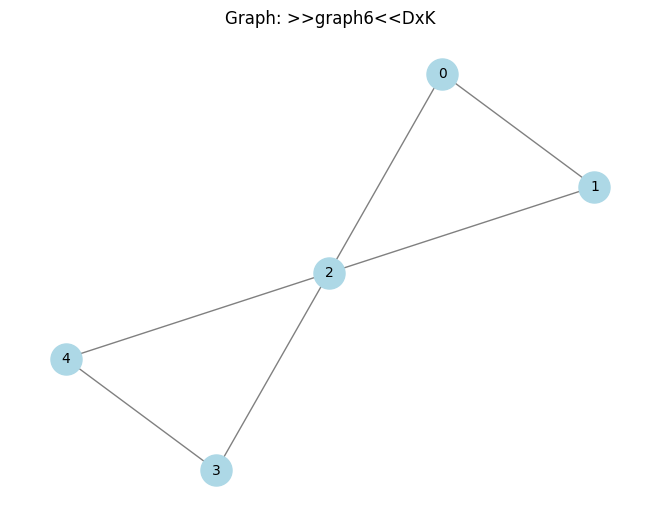

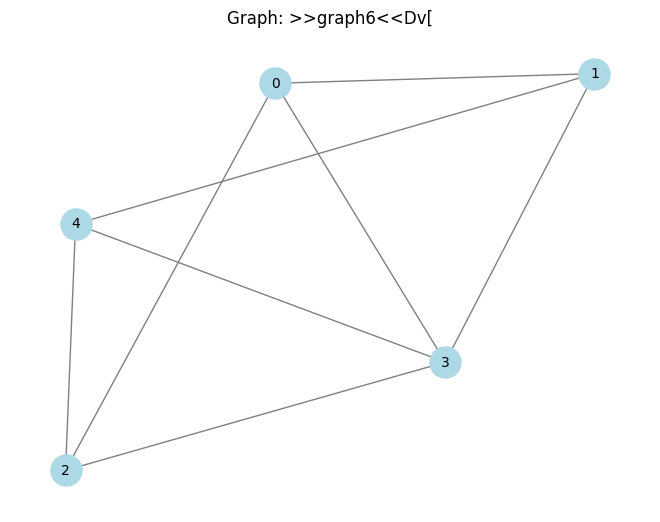

In [6]:


for graph6_string in results['graph_name'].unique():
    nx_graph = nx.from_graph6_bytes(graph6_string.encode('utf-8'))
    nx.draw(nx_graph, with_labels=True, node_color='lightblue', edge_color='gray', node_size=500, font_size=10)
    plt.title(f"Graph: {graph6_string}")
    plt.show()